In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [137]:
def clean_up_observations_and_add_rain_class(atg_obs_selected):
    no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()

    no_erros_obs['datetime_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).tz_localize('UTC').tz_convert('US/Pacific')
    no_erros_obs['Date_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).date
    no_erros_obs['Time_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).time
    no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
    no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
    no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
    no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='30min')
    summed_rain_each_period = first_obs_each_period['Rain'].sum()

    # lightrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.0)]
    # summed_rain_each_period.loc[lightrainfall_times.index] = 1

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date_PST'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time_PST'].first()
    atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
    atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
    atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
    atg_obs_necessary['rainfall_type'] = summed_rain_each_period

    atg_obs_necessary = atg_obs_necessary.dropna()

    return atg_obs_necessary

In [3]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))

In [146]:
atg_obs_selected = atg_obs.copy() # Selecting dates
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2022,5,1))]

In [147]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary = clean_up_observations_and_add_rain_class(atg_obs_selected)
atg_obs_necessary

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2022-05-01 00:00:00,2022-04-30,17:00:00,60.7,1011.5,43.0,0.0
2022-05-01 00:30:00,2022-04-30,17:30:00,59.8,1011.8,47.5,0.0
2022-05-01 01:00:00,2022-04-30,18:00:00,59.6,1012.1,51.4,0.0
2022-05-01 01:30:00,2022-04-30,18:30:00,58.7,1012.3,55.4,0.0
2022-05-01 02:00:00,2022-04-30,19:00:00,58.1,1012.8,53.9,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


In [56]:
def select_times_around_specific_events(atg_obs_necessary, event, num_days_around):
    notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=event].index

    relevant_events = pd.DataFrame()
    for event_time in notable_event_times:
        start_time = event_time-pd.Timedelta(days=num_days_around)
        end_time = event_time+pd.Timedelta(days=num_days_around)
        time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
        relevant_events = pd.concat([relevant_events, time_around_event]).drop_duplicates()
    
    return relevant_events

In [57]:
relevant_events = select_times_around_specific_events(atg_obs_necessary, 1, 30)
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2022-05-01 00:00:00,2022-04-30,17:00:00,60.7,1011.5,43.0,0.0
2022-05-01 00:30:00,2022-04-30,17:30:00,59.8,1011.8,47.5,0.0
2022-05-01 01:00:00,2022-04-30,18:00:00,59.6,1012.1,51.4,0.0
2022-05-01 01:30:00,2022-04-30,18:30:00,58.7,1012.3,55.4,0.0
2022-05-01 02:00:00,2022-04-30,19:00:00,58.1,1012.8,53.9,0.0
...,...,...,...,...,...,...
2024-05-23 15:30:00,2024-05-23,08:30:00,52.8,1017.1,67.8,0.0
2024-05-23 16:00:00,2024-05-23,09:00:00,53.2,1017.0,66.1,0.0
2024-05-23 16:30:00,2024-05-23,09:30:00,53.2,1017.1,65.3,0.0


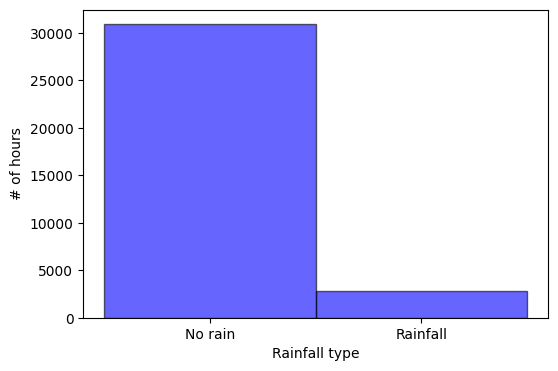

(array([30903,  2825]), array([0., 1., 2.]))

In [59]:
rain_counts, classes = np.histogram(relevant_events['rainfall_type'].values, bins=np.arange(0,relevant_events['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,relevant_events['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_events['rainfall_type'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [60]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M:%S')

    months = pd.DatetimeIndex(date_objs).month
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    processed_df['months_from_july'] = months
    # processed_df['time_of_day'] = ((hours-4)%24) / 6

    vals = dataset['temperature']
    processed_df['feature_1'] = vals.values

    vals = dataset['relhum']
    processed_df['feature_2'] = vals.values

    vals = dataset['pressure']
    processed_df['feature_3'] = vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [61]:
def create_balanced_df(processed_df):
    ones_samps = processed_df[processed_df['class']==1].copy()
    num_ones = ones_samps.shape[0]

    dupl_processed_df = ones_samps
    group = 0
    under_group_samps = processed_df[processed_df['class']==group].copy()
    group_samps = under_group_samps.sample(n=(num_ones), replace=False, random_state=42)

    dupl_processed_df = pd.concat([dupl_processed_df, group_samps])

    return dupl_processed_df

In [62]:
raw_df_train_val, raw_under_df_test = train_test_split(relevant_events,random_state=42,test_size=0.2)
raw_under_df_train, raw_under_df_val = train_test_split(raw_df_train_val,random_state=42,test_size=0.25)

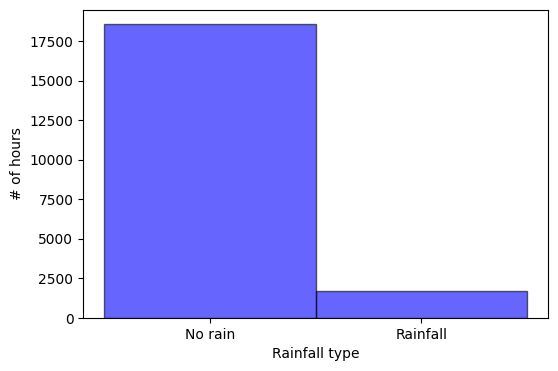

(array([18554,  1682]), array([0., 1., 2.]))

In [63]:
under_sam_reltimes_tr = get_processed_df_from_data(raw_under_df_train)
rain_counts, classes = np.histogram(under_sam_reltimes_tr['class'].values, bins=np.arange(0,under_sam_reltimes_tr['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,under_sam_reltimes_tr['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,under_sam_reltimes_tr['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [64]:
processed_df_train = create_balanced_df(under_sam_reltimes_tr)
processed_df_train

,months_from_july,feature_1,feature_2,feature_3,class
3,1,44.2,88.0,997.3,1.0
4,12,46.5,87.2,1006.2,1.0
6,3,51.8,94.8,1014.3,1.0
25,2,42.4,94.8,1020.8,1.0
36,12,55.2,92.9,1007.5,1.0
...,...,...,...,...,...
11856,3,49.2,67.2,1024.7,0.0
14396,7,63.3,76.6,1017.1,0.0
6843,8,61.0,81.2,1009.8,0.0
17252,12,51.0,83.0,1011.1,0.0


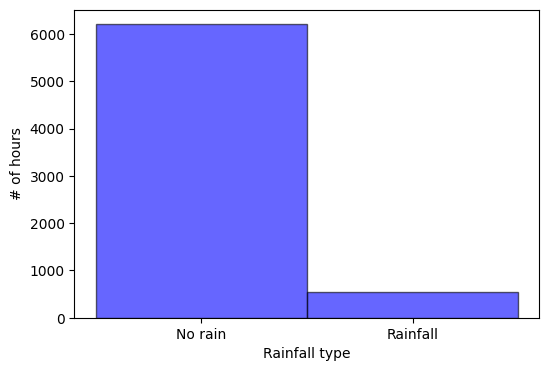

(array([6203,  543]), array([0., 1., 2.]))

In [65]:
processed_df_val = get_processed_df_from_data(raw_under_df_val)
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_val['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_val['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,processed_df_val['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [66]:
# processed_df_val = create_balanced_df(under_sam_reltimes_va)
processed_df_val

,months_from_july,feature_1,feature_2,feature_3,class
0,9,61.7,68.8,1008.0,0.0
1,2,43.8,84.1,1018.5,0.0
2,6,58.3,46.6,1012.1,0.0
3,2,46.0,51.9,1009.0,0.0
4,1,36.8,97.0,994.0,1.0
...,...,...,...,...,...
6741,8,61.4,68.7,1014.4,0.0
6742,5,49.3,86.1,1005.8,1.0
6743,8,71.3,65.9,1012.9,0.0
6744,8,82.6,35.6,1010.1,0.0


In [67]:
processed_df_train.shape, processed_df_val.shape

((3364, 5), (6746, 5))

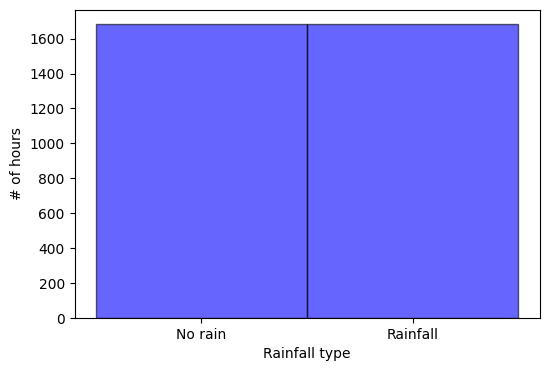

(array([1682, 1682]), array([0., 1., 2.]))

In [68]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

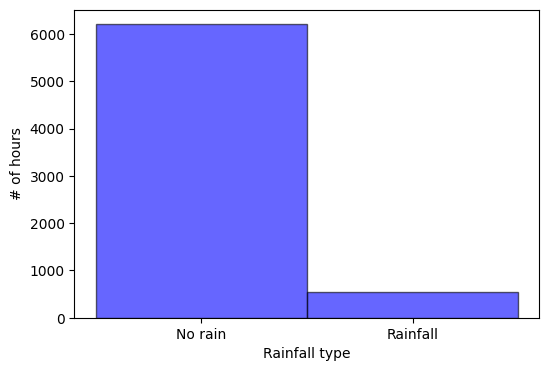

(array([6203,  543]), array([0., 1., 2.]))

In [69]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

In [70]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train.shape

(3364, 5)

In [71]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val.shape

(6746, 5)

In [72]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_train_labs = processed_data_train[:, processed_data_train.shape[1]-1:]
y_data_train = to_categorical(y_train_labs, int(y_train_labs.max()+1))
print(x_data_train[0], y_data_train[0])

[  1.   44.2  88.  997.3] [0. 1.]


In [73]:
x_data_val = processed_data_val[:, :processed_data_val.shape[1]-1]
y_val_labs = processed_data_val[:, processed_data_val.shape[1]-1:]
y_data_val = to_categorical(y_val_labs, int(y_val_labs.max()+1))
print(x_data_val[0], y_data_val[0])

[   9.    61.7   68.8 1008. ] [1. 0.]


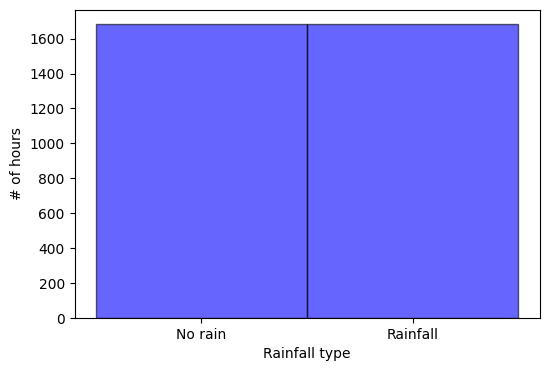

(array([1682, 1682]), array([0., 1., 2.]))

In [74]:
rain_counts, classes = np.histogram(y_train_labs, bins=np.arange(0,y_train_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_train_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_train_labs.max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

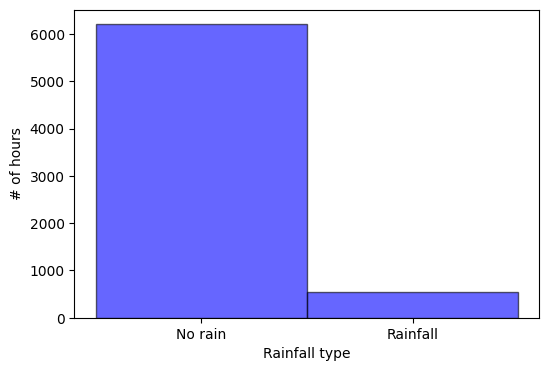

(array([6203,  543]), array([0., 1., 2.]))

In [75]:
rain_counts, classes = np.histogram(y_val_labs, bins=np.arange(0,y_val_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_val_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_val_labs.max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_data_train)
X_val_scaled = scaler.transform(x_data_val)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(x_data_train.shape[1],)))

# Hidden layers
model.add(layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(int(y_train_labs.max()+1), activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               640       
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 2)                 130       
                                                                 
Total params: 42,050
Trainable params: 42,050
Non-trai

In [77]:
X_train_scaled.shape, y_data_train.shape

((3364, 4), (3364, 2))

In [78]:
X_val_scaled.shape, y_data_val.shape

((6746, 4), (6746, 2))

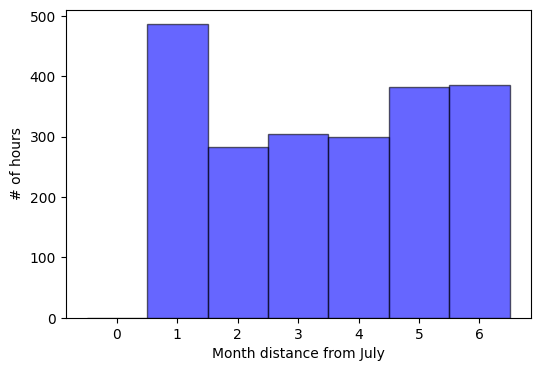

(array([  0, 486, 283, 304, 300, 383, 386]), array([0, 1, 2, 3, 4, 5, 6, 7]))

In [79]:
binwidth = 1
rain_counts, classes = np.histogram(x_data_train[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [80]:
X_train_scaled

array([[-1.33182948, -0.70080397,  0.64920633, -1.54961916],
       [ 1.57435156, -0.47663802,  0.6007584 , -0.44333584],
       [-0.80343293,  0.0399183 ,  1.06101381,  0.56350627],
       ...,
       [ 0.51755845,  0.93658209,  0.23739886,  0.00414954],
       [ 1.57435156, -0.03805247,  0.34640672,  0.16574149],
       [-0.53923465, -1.22710663,  0.79455015, -0.1574424 ]])

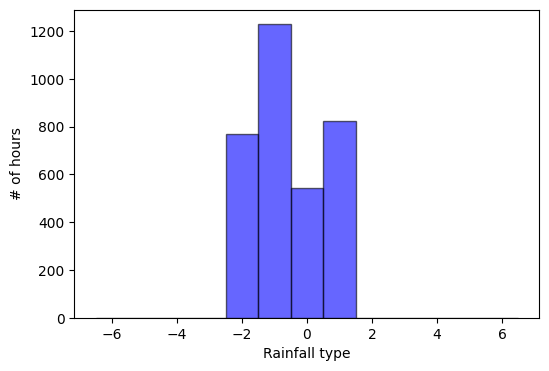

(array([   0,    0,    0,    0,  769, 1228,  544,  823,    0,    0,    0,
           0,    0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [81]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [82]:
scaler.mean_, scaler.scale_

(array([   6.04102259,   51.39042806,   77.2799346 , 1009.76661712]),
 array([ 3.78503605, 10.26025591, 16.51257057,  8.04495546]))

In [83]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_data_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_data_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


2024-06-02 11:58:50.723959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - ETA: 0s - loss: 0.7176 - accuracy: 0.8035

2024-06-02 11:58:52.669907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


106/106 [==============================] - 4s 35ms/step - loss: 0.7176 - accuracy: 0.8035 - val_loss: 0.6525 - val_accuracy: 0.7885 - lr: 0.0010
Epoch 2/100
106/106 [==============================] - 3s 33ms/step - loss: 0.5872 - accuracy: 0.8255 - val_loss: 0.5182 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 3/100
106/106 [==============================] - 3s 32ms/step - loss: 0.5375 - accuracy: 0.8181 - val_loss: 0.5223 - val_accuracy: 0.8150 - lr: 0.0010
Epoch 4/100
106/106 [==============================] - 3s 31ms/step - loss: 0.5060 - accuracy: 0.8240 - val_loss: 0.5324 - val_accuracy: 0.7925 - lr: 0.0010
Epoch 5/100
106/106 [==============================] - 3s 31ms/step - loss: 0.4878 - accuracy: 0.8228 - val_loss: 0.5353 - val_accuracy: 0.7854 - lr: 0.0010
Epoch 6/100
106/106 [==============================] - 3s 33ms/step - loss: 0.4787 - accuracy: 0.8210 - val_loss: 0.4623 - val_accuracy: 0.8046 - lr: 0.0010
Epoch 7/100
106/106 [==============================] - 3s 31ms/step - 

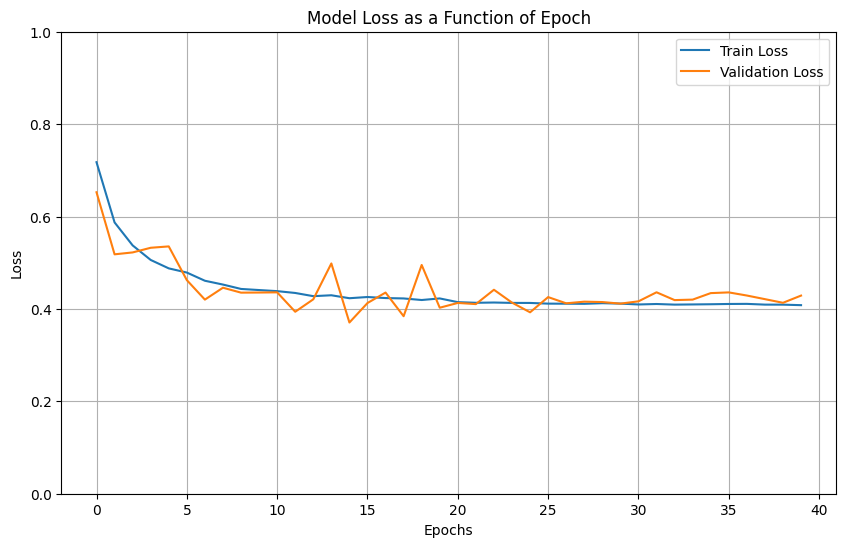

In [148]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

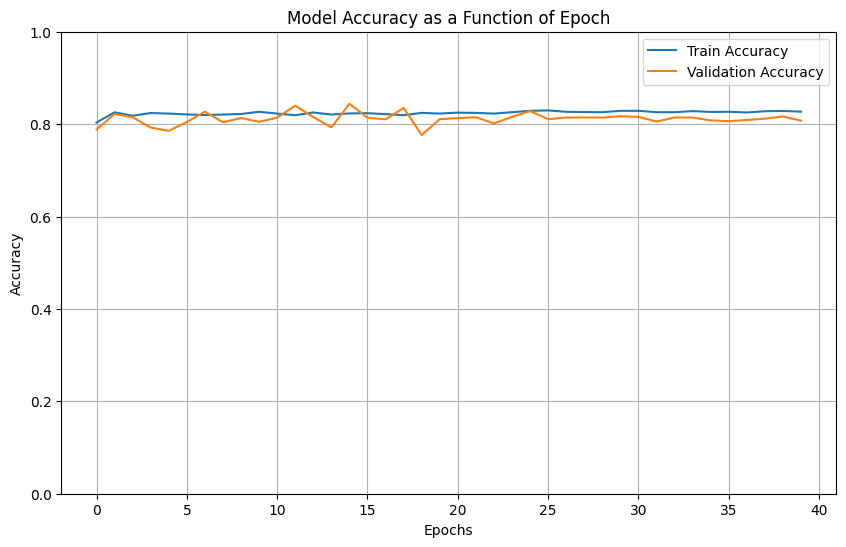

In [85]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

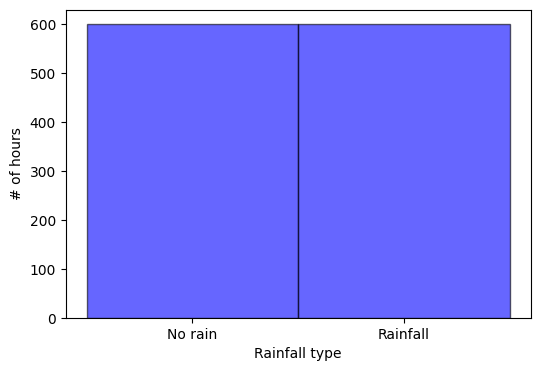

[600 600] [0. 1. 2.]
[  2.   48.5  88.  990.9] [0. 1.]


In [149]:
under_sam_reltimes_te = get_processed_df_from_data(raw_under_df_test)
processed_df_test = create_balanced_df(under_sam_reltimes_te)

rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
print(rain_counts, classes)

processed_data_test = processed_df_test.values.astype(float)
x_data_test = processed_data_test[:, :processed_data_test.shape[1]-1]
y_test_labs = processed_data_test[:, processed_data_test.shape[1]-1:]
y_data_test = to_categorical(y_test_labs, int(y_test_labs.max()+1))
print(x_data_test[0], y_data_test[0])

In [150]:
scaler.mean_, scaler.scale_

(array([   6.04102259,   51.39042806,   77.2799346 , 1009.76661712]),
 array([ 3.78503605, 10.26025591, 16.51257057,  8.04495546]))

In [151]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test, verbose=2)

38/38 [==============================] - 0s 4ms/step
38/38 - 0s - loss: 0.4132 - accuracy: 0.8308 - 441ms/epoch - 12ms/step


[0.4132217466831207, 0.8308333158493042]

Confusion Matrix:
[[517  83]
 [120 480]]


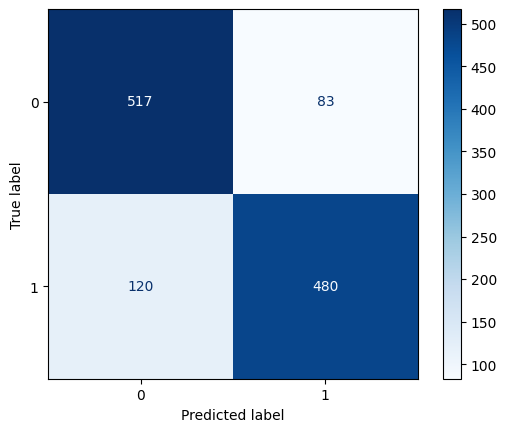

In [152]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[517  83]
 [120 480]]


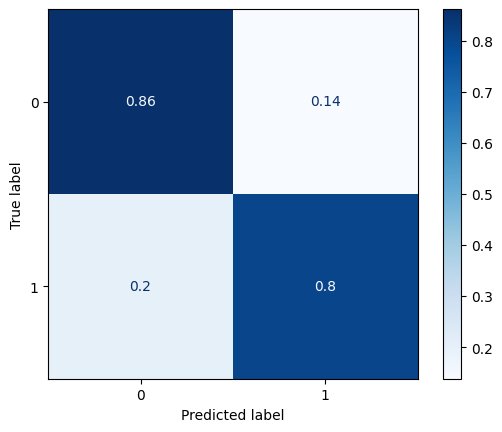

In [153]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(2, 1)), display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [154]:
f1_score(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1), average=None)

array([0.83589329, 0.82545142])

In [155]:
def create_oversampled_df_from_raw(processed_df):
    num_zeros = processed_df[processed_df['rainfall_type']==0].shape[0]

    zeros_samps = processed_df[processed_df['rainfall_type']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 3):
        under_group_samps = processed_df[processed_df['rainfall_type']==group].copy()
        if len(under_group_samps)>0:
            group_samps = under_group_samps.sample(n=(num_zeros-len(under_group_samps)), replace=True, random_state=42)
            
            np.random.seed(1)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['temperature'] = group_samps['temperature']+noise

            np.random.seed(2)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['pressure'] = group_samps['pressure']+noise

            np.random.seed(3)
            noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
            group_samps['relhum'] = group_samps['relhum']+noise

            dupl_processed_df = pd.concat([dupl_processed_df, under_group_samps, group_samps])

    return dupl_processed_df

In [156]:
raw_under_df_test

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-05-11 17:00:00,2023-05-11,10:00:00,63.3,1017.3,52.3,0.0
2024-02-29 06:00:00,2024-02-28,22:00:00,48.5,990.9,88.0,1.0
2022-08-03 03:30:00,2022-08-02,20:30:00,72.5,1011.1,52.5,0.0
2023-02-03 09:00:00,2023-02-03,01:00:00,45.2,1010.2,52.1,0.0
2022-12-19 23:00:00,2022-12-19,15:00:00,34.0,1021.0,85.0,0.0
...,...,...,...,...,...,...
2023-07-05 12:30:00,2023-07-05,05:30:00,64.2,1010.8,72.2,0.0
2023-06-05 18:00:00,2023-06-05,11:00:00,63.7,1017.5,47.2,0.0
2023-12-22 23:30:00,2023-12-22,15:30:00,45.0,1014.2,87.0,0.0


In [157]:
import calendar

18/18 [==============================] - 0s 4ms/step


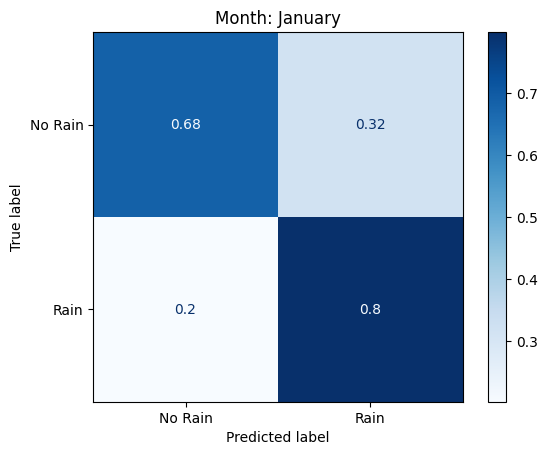

19/19 [==============================] - 0s 5ms/step


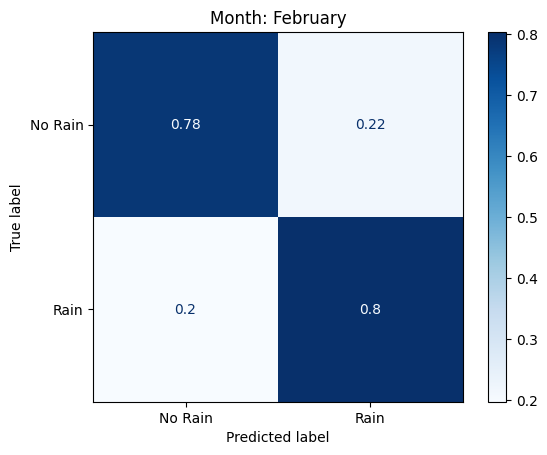

19/19 [==============================] - 0s 3ms/step


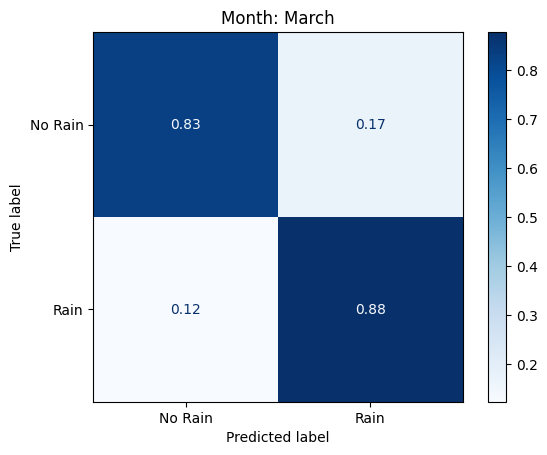

18/18 [==============================] - 0s 3ms/step


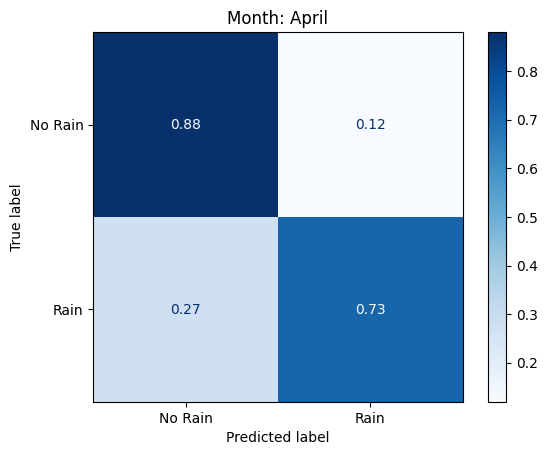

24/24 [==============================] - 0s 3ms/step


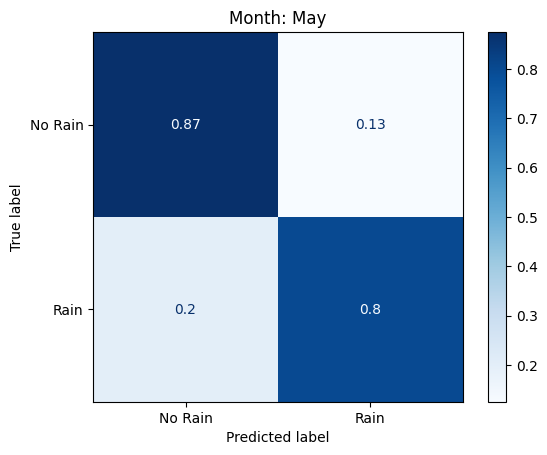

17/17 [==============================] - 0s 4ms/step


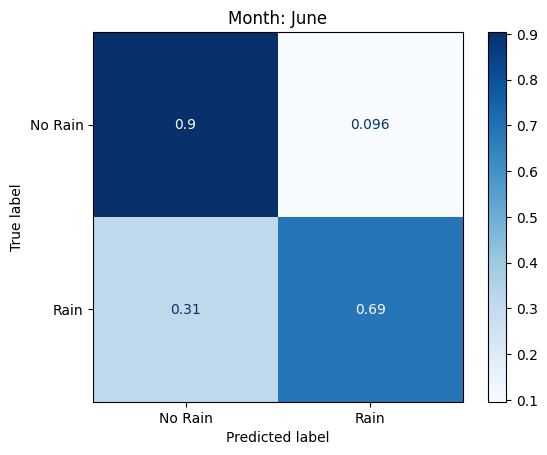

20/20 [==============================] - 0s 3ms/step


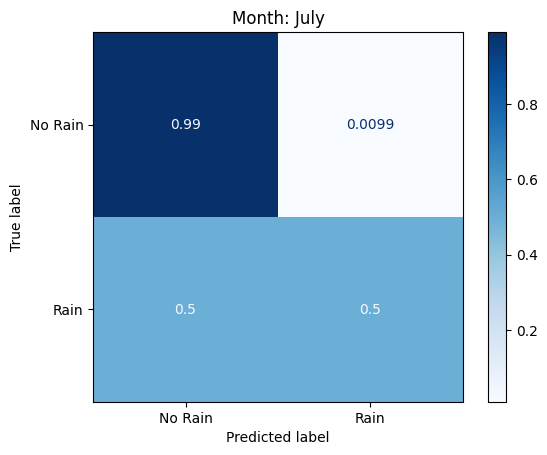

19/19 [==============================] - 0s 3ms/step


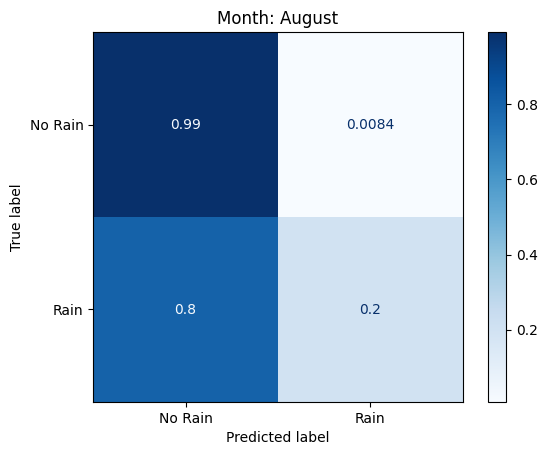

19/19 [==============================] - 0s 3ms/step


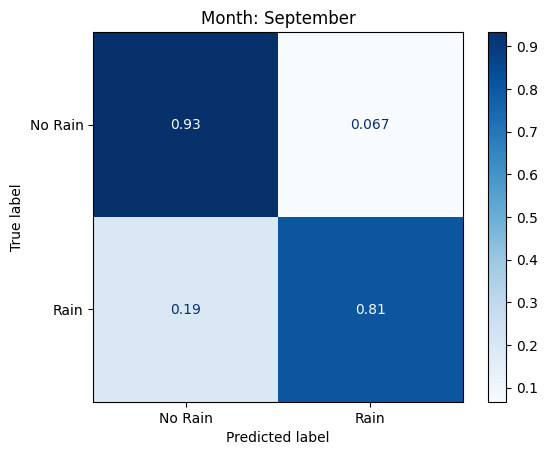

9/9 [==============================] - 0s 3ms/step


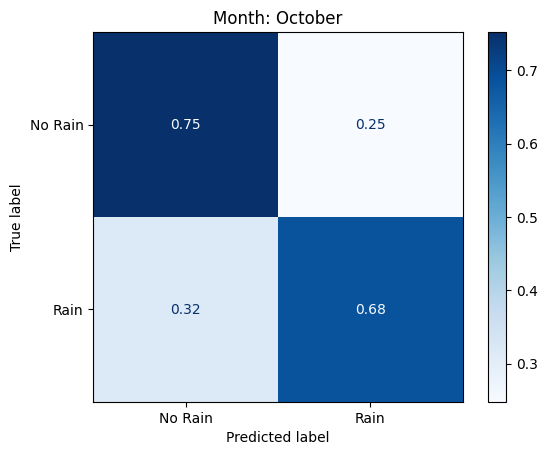

15/15 [==============================] - 0s 3ms/step


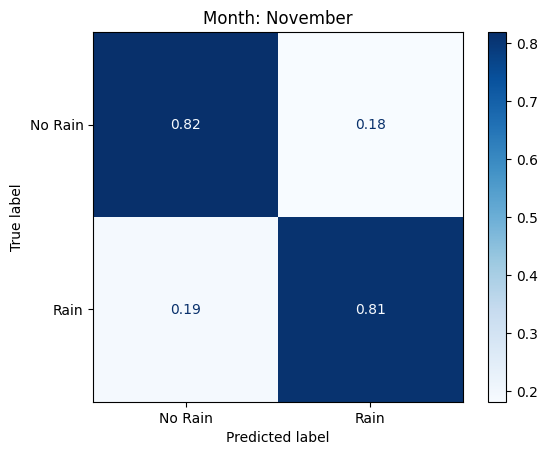

19/19 [==============================] - 0s 3ms/step


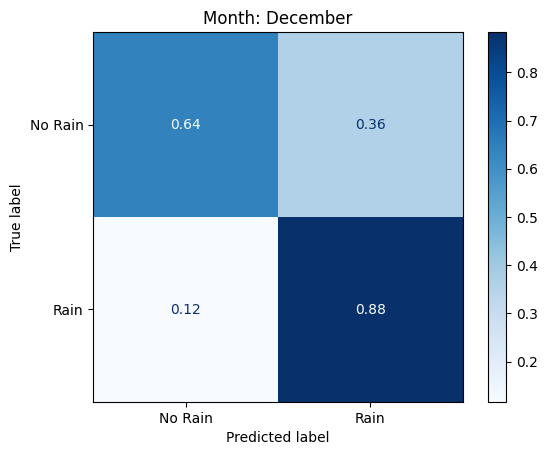

In [163]:
for month_num in np.arange(1, 13):
    test_data_sorted_month = raw_under_df_test.loc[(pd.DatetimeIndex(raw_under_df_test['date']).month==month_num), :].sort_index()
    # processed_test_sorted_month_balanced_raw = create_oversampled_df_from_raw(test_data_sorted_month).sort_index()
    processed_test_sorted_month = get_processed_df_from_data(test_data_sorted_month)
    processed_data_test_month = processed_test_sorted_month.values.astype(float)
    x_data_test_month = processed_data_test_month[:, :processed_data_test_month.shape[1]-1]
    y_test_labs_month = processed_data_test_month[:, processed_data_test_month.shape[1]-1:]
    y_data_test_month = to_categorical(y_test_labs_month, 3)

    X_test_scaled_month = scaler.transform(x_data_test_month)
    predictions_month = model.predict(X_test_scaled_month)

    cm = confusion_matrix(np.argmax(y_data_test_month, axis=1), np.argmax(predictions_month,axis=1))

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(2, 1)), display_labels=['No Rain', 'Rain'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Month: {calendar.month_name[month_num]}')
    plt.show()

In [159]:
# Assuming you have already trained your model
model.save('../models/2class_weather_for30.h5')

In [160]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("../models/2class_weather_for30.tflite", "wb").write(tflite_model)

import os
basic_model_size = os.path.getsize("../models/2class_weather_for30.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmprepwivd7/assets
Model is 171048 bytes


2024-06-02 14:54:21.311817: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-06-02 14:54:21.311833: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-06-02 14:54:21.312943: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmprepwivd7
2024-06-02 14:54:21.315050: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-06-02 14:54:21.315058: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmprepwivd7
2024-06-02 14:54:21.322264: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-06-02 14:54:21.324424: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-06-02 14:54:21.387545: I tensorflow/cc/saved_model/loader.

In [161]:
!echo "const unsigned char model[] = {" > ../arduino/2class_model_for30.h
!cat ../models/2class_weather_for30.tflite | xxd -i      >> ../arduino/2class_model_for30.h
!echo "};"                              >> ../arduino/2class_model_for30.h

In [162]:
import os
model_h_size = os.path.getsize("../arduino/2class_model_for30.h")
print(f"Header file, 2class_model_for30.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, 2class_model_for30.h, is 1,054,830 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
